# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Loading the data and exploring

In [2]:
df_org = pd.read_csv('Fraud.csv')
df_org.head() 

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df_org.shape

(6362620, 11)

In [4]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df_org.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
# Check for duplicates in the dataset
duplicates = df_org.duplicated()
num_duplicates = duplicates.sum()

if num_duplicates > 0:
    print(f"There are {num_duplicates} duplicate rows in the dataset.")
else:
    print("There are no duplicate rows in the dataset.")


There are no duplicate rows in the dataset.


In [7]:
df_org.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [8]:
df_org.type.value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

# Featuring Engineering

In [9]:
# Convert steps to days
df_org['days'] = (df_org['step'] - 1) // 24 + 1

df_org.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,days
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1


In [10]:
df_org.days.value_counts()

days
1     574255
2     455238
8     449637
6     441005
13    428583
17    425766
7     420583
9     417919
11    417859
15    401282
14    397876
10    392945
16    375594
12    349776
25     57853
29     54890
22     53437
23     51012
24     32709
4      28240
21     24593
18     20999
20     19727
28     14661
26     13885
19     11300
30     11287
5       9789
27      8578
3       1070
31       272
Name: count, dtype: int64

In [11]:
# Extract hour of the day
df_org['hour_of_day'] = (df_org['step'] - 1) % 24

# Print the result
df_org.hour_of_day.value_counts()


hour_of_day
18    647814
17    580509
19    553728
11    483418
12    468474
10    445992
15    441612
16    439941
13    439653
9     425729
14    416686
8     283518
20    247806
21    194555
22    141257
23     71587
0      27111
7      26915
1       9018
6       8988
5       3420
2       2007
4       1641
3       1241
Name: count, dtype: int64

In [12]:
# Define the time periods
time_periods = {
    'Early_Morning': range(0, 6),
    'Morning': range(6, 12),
    'Noon': range(12, 13),
    'Afternoon': range(13, 18),
    'Evening': range(18, 21),
    'Night': range(21, 24)
}

# Create a new column for time periods
df_org['time_period'] = df_org['hour_of_day'].apply(lambda hour: next((tp for tp, hours in time_periods.items() if hour in hours), 'Unknown'))

df_org.time_period.value_counts()


time_period
Afternoon        2318401
Morning          1674560
Evening          1449348
Noon              468474
Night             407399
Early_Morning      44438
Name: count, dtype: int64

In [13]:
df_org.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,days,hour_of_day,time_period
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1,0,Early_Morning
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1,0,Early_Morning
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1,0,Early_Morning
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,0,Early_Morning
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1,0,Early_Morning


In [14]:
# Perform one-hot encoding on the "type" column
type_encoded = pd.get_dummies(df_org['type'], prefix='type')


# Convert the encoded values to 1 and 0
type_encoded = type_encoded.astype(int)


# Concatenate the encoded columns to the original DataFrame
df_org_encoded = pd.concat([df_org, type_encoded], axis=1)

# Print the encoded DataFrame
df_org_encoded.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,days,hour_of_day,time_period,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1,0,Early_Morning,0,0,0,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1,0,Early_Morning,0,0,0,1,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1,0,Early_Morning,0,0,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,0,Early_Morning,0,1,0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1,0,Early_Morning,0,0,0,1,0


In [15]:
# Perform one-hot encoding on the "time_period" column
time_period_encoded = pd.get_dummies(df_org['time_period'], prefix='time_period')

# Convert the encoded values to 1 and 0
time_period_encoded = time_period_encoded.astype(int)

# Concatenate the encoded columns to the original DataFrame
df_org_encoded = pd.concat([df_org_encoded, time_period_encoded], axis=1)

# Print the encoded DataFrame
df_org_encoded.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,time_period_Afternoon,time_period_Early_Morning,time_period_Evening,time_period_Morning,time_period_Night,time_period_Noon
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,...,0,0,1,0,0,1,0,0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,...,0,0,1,0,0,1,0,0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,...,0,0,0,1,0,1,0,0,0,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,...,1,0,0,0,0,1,0,0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,...,0,0,1,0,0,1,0,0,0,0


In [16]:
# Counting transactions made by each customer in nameOrig
transaction_counts_orig = df_org_encoded.groupby('nameOrig').size().reset_index(name='num_transactions_orig')

# Merging the count information back into the original dataset
df = pd.merge(df_org_encoded, transaction_counts_orig, on='nameOrig', how='left')


In [17]:
# Counting transactions received by each customer in nameDest
transaction_counts_dest = df_org_encoded.groupby('nameDest').size().reset_index(name='num_transactions_dest')

# Merging the count information back into the original dataset
df = pd.merge(df, transaction_counts_dest, on='nameDest', how='left')


In [18]:
pd.set_option('display.max_columns', None)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,days,hour_of_day,time_period,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,time_period_Afternoon,time_period_Early_Morning,time_period_Evening,time_period_Morning,time_period_Night,time_period_Noon,num_transactions_orig,num_transactions_dest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1,0,Early_Morning,0,0,0,1,0,0,1,0,0,0,0,1,1
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1,0,Early_Morning,0,0,0,1,0,0,1,0,0,0,0,1,1
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1,0,Early_Morning,0,0,0,0,1,0,1,0,0,0,0,1,44
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,0,Early_Morning,0,1,0,0,0,0,1,0,0,0,0,1,41
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1,0,Early_Morning,0,0,0,1,0,0,1,0,0,0,0,1,1


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 27 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   step                       int64  
 1   type                       object 
 2   amount                     float64
 3   nameOrig                   object 
 4   oldbalanceOrg              float64
 5   newbalanceOrig             float64
 6   nameDest                   object 
 7   oldbalanceDest             float64
 8   newbalanceDest             float64
 9   isFraud                    int64  
 10  isFlaggedFraud             int64  
 11  days                       int64  
 12  hour_of_day                int64  
 13  time_period                object 
 14  type_CASH_IN               int32  
 15  type_CASH_OUT              int32  
 16  type_DEBIT                 int32  
 17  type_PAYMENT               int32  
 18  type_TRANSFER              int32  
 19  time_period_Afternoon      int32  
 20  ti

In [20]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,days,hour_of_day,time_period,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,time_period_Afternoon,time_period_Early_Morning,time_period_Evening,time_period_Morning,time_period_Night,time_period_Noon,num_transactions_orig,num_transactions_dest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1,0,Early_Morning,0,0,0,1,0,0,1,0,0,0,0,1,1
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1,0,Early_Morning,0,0,0,1,0,0,1,0,0,0,0,1,1
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1,0,Early_Morning,0,0,0,0,1,0,1,0,0,0,0,1,44
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,0,Early_Morning,0,1,0,0,0,0,1,0,0,0,0,1,41
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1,0,Early_Morning,0,0,0,1,0,0,1,0,0,0,0,1,1


In [21]:
# Drop the specified columns
df = df.drop(['step', 'type', 'time_period', 'nameOrig', 'nameDest'], axis=1)

# Print the updated DataFrame
df.head()


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,days,hour_of_day,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,time_period_Afternoon,time_period_Early_Morning,time_period_Evening,time_period_Morning,time_period_Night,time_period_Noon,num_transactions_orig,num_transactions_dest
0,9839.64,170136.0,160296.36,0.0,0.0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1
1,1864.28,21249.0,19384.72,0.0,0.0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1
2,181.00,181.0,0.00,0.0,0.0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,44
3,181.00,181.0,0.00,21182.0,0.0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,41
4,11668.14,41554.0,29885.86,0.0,0.0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 22 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   amount                     float64
 1   oldbalanceOrg              float64
 2   newbalanceOrig             float64
 3   oldbalanceDest             float64
 4   newbalanceDest             float64
 5   isFraud                    int64  
 6   isFlaggedFraud             int64  
 7   days                       int64  
 8   hour_of_day                int64  
 9   type_CASH_IN               int32  
 10  type_CASH_OUT              int32  
 11  type_DEBIT                 int32  
 12  type_PAYMENT               int32  
 13  type_TRANSFER              int32  
 14  time_period_Afternoon      int32  
 15  time_period_Early_Morning  int32  
 16  time_period_Evening        int32  
 17  time_period_Morning        int32  
 18  time_period_Night          int32  
 19  time_period_Noon           int32  
 20  nu

In [23]:
# Calculate the difference in balances for the originating account
df['balance_diff_orig'] = df['newbalanceOrig'] - df['oldbalanceOrg']

# Calculate the difference in balances for the destination account
df['balance_diff_dest'] = df['newbalanceDest'] - df_org_encoded['oldbalanceDest']


In [24]:
df.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,days,hour_of_day,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,time_period_Afternoon,time_period_Early_Morning,time_period_Evening,time_period_Morning,time_period_Night,time_period_Noon,num_transactions_orig,num_transactions_dest,balance_diff_orig,balance_diff_dest
0,9839.64,170136.0,160296.36,0.0,0.0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1,-9839.64,0.0
1,1864.28,21249.0,19384.72,0.0,0.0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1,-1864.28,0.0
2,181.00,181.0,0.00,0.0,0.0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,44,-181.00,0.0
3,181.00,181.0,0.00,21182.0,0.0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,41,-181.00,-21182.0
4,11668.14,41554.0,29885.86,0.0,0.0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1,-11668.14,0.0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 24 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   amount                     float64
 1   oldbalanceOrg              float64
 2   newbalanceOrig             float64
 3   oldbalanceDest             float64
 4   newbalanceDest             float64
 5   isFraud                    int64  
 6   isFlaggedFraud             int64  
 7   days                       int64  
 8   hour_of_day                int64  
 9   type_CASH_IN               int32  
 10  type_CASH_OUT              int32  
 11  type_DEBIT                 int32  
 12  type_PAYMENT               int32  
 13  type_TRANSFER              int32  
 14  time_period_Afternoon      int32  
 15  time_period_Early_Morning  int32  
 16  time_period_Evening        int32  
 17  time_period_Morning        int32  
 18  time_period_Night          int32  
 19  time_period_Noon           int32  
 20  nu

In [26]:
df.isFraud.value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

# Correlation Analysis

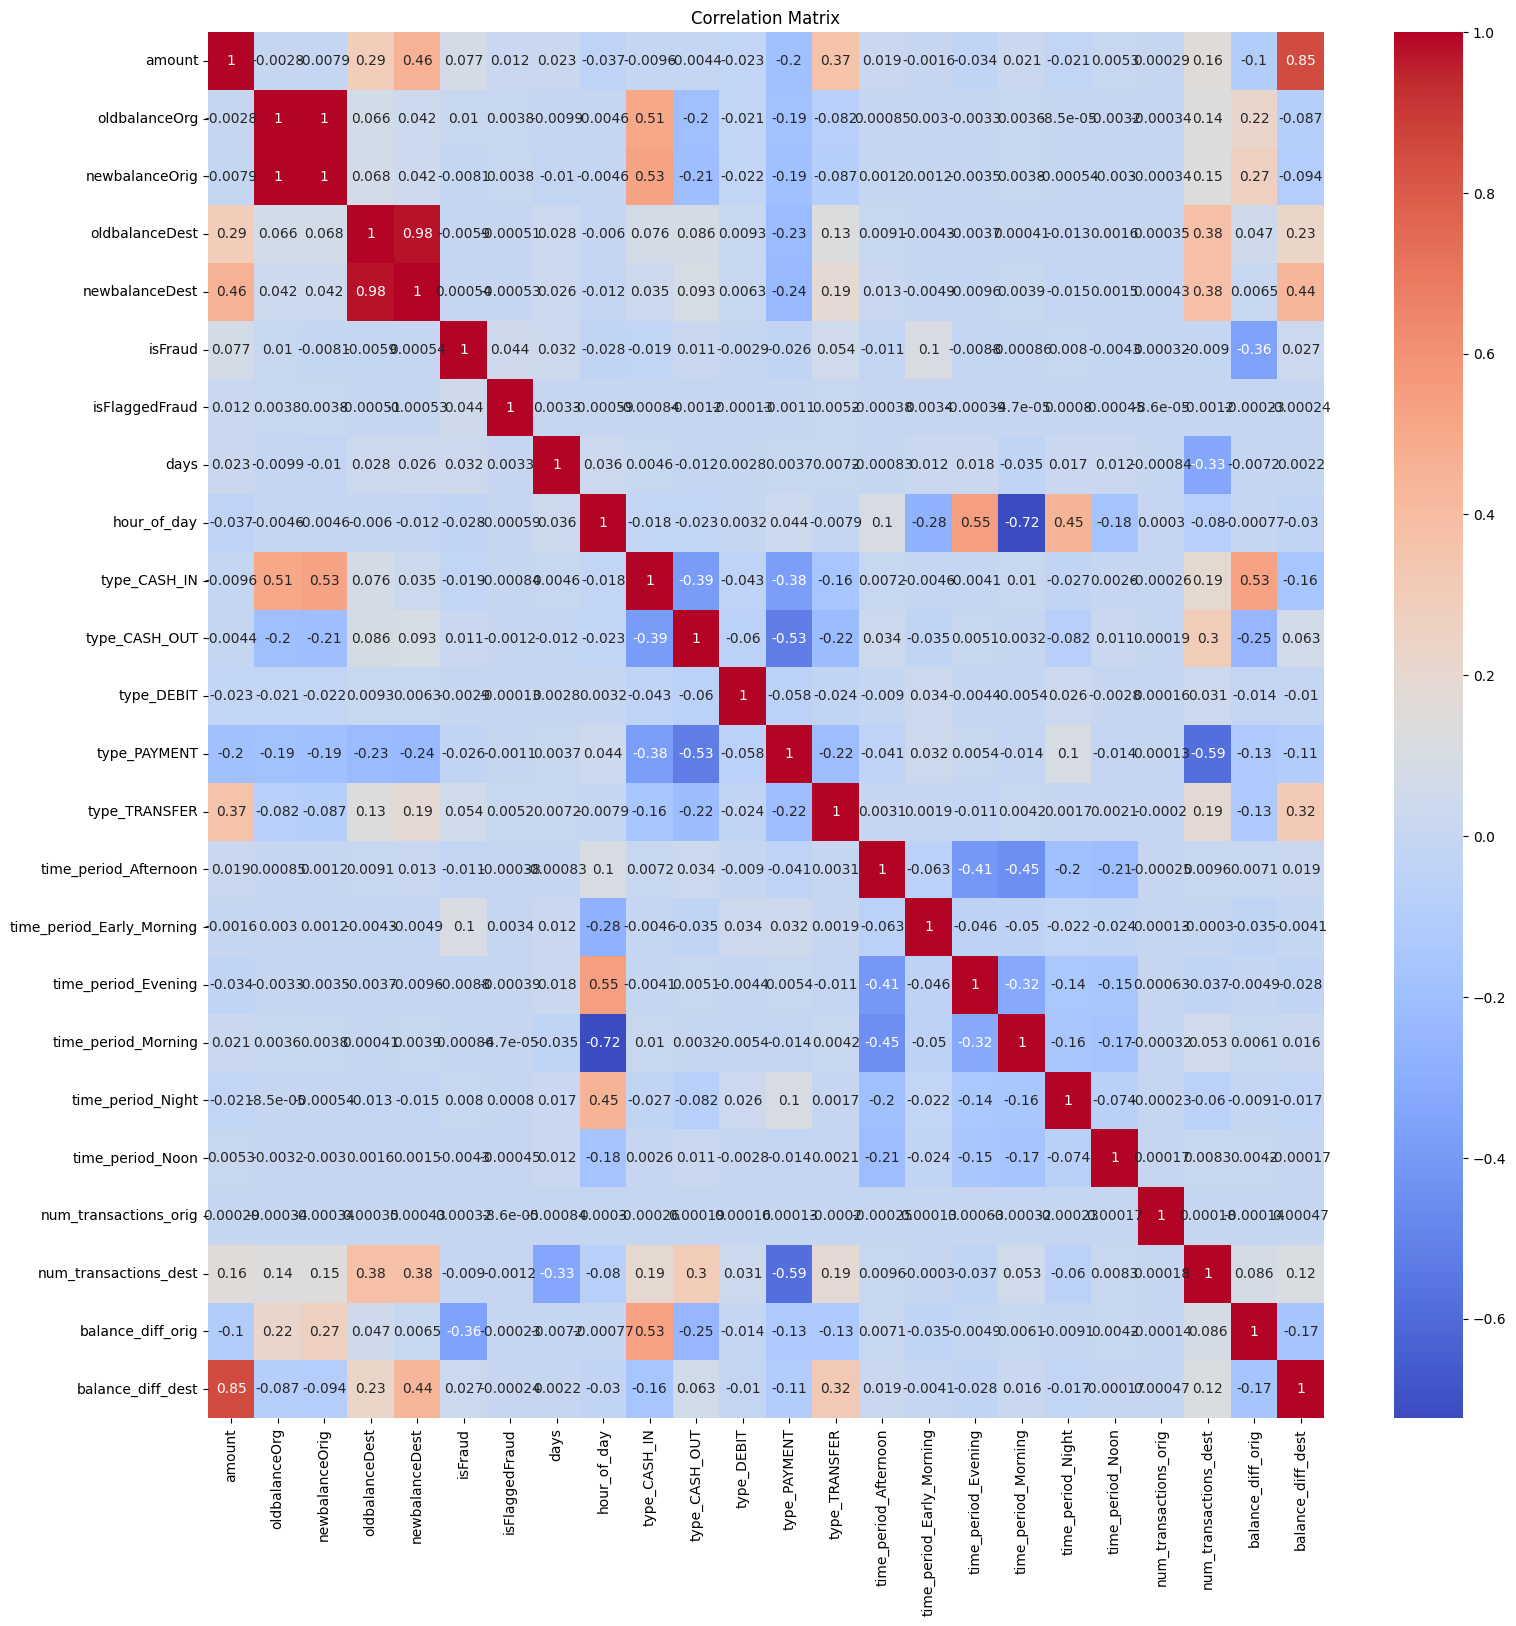

In [27]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Set the figure size
plt.figure(figsize=(18, 18))

# Create a heatmap for the correlation matrix
sb.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Set the title of the plot
plt.title('Correlation Matrix')

# Show the plot
plt.show()


In [28]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Iterate over the columns and their correlation values
for column in corr_matrix.columns:
    correlated_columns = corr_matrix[column][abs(corr_matrix[column]) >= 0.8].index
    if len(correlated_columns) > 1:
        print(f"Correlated columns with '{column}':")
        print(corr_matrix.loc[correlated_columns, correlated_columns])
        print('_' * 100)
        print()


Correlated columns with 'amount':
                     amount  balance_diff_dest
amount             1.000000           0.845964
balance_diff_dest  0.845964           1.000000
____________________________________________________________________________________________________

Correlated columns with 'oldbalanceOrg':
                oldbalanceOrg  newbalanceOrig
oldbalanceOrg        1.000000        0.998803
newbalanceOrig       0.998803        1.000000
____________________________________________________________________________________________________

Correlated columns with 'newbalanceOrig':
                oldbalanceOrg  newbalanceOrig
oldbalanceOrg        1.000000        0.998803
newbalanceOrig       0.998803        1.000000
____________________________________________________________________________________________________

Correlated columns with 'oldbalanceDest':
                oldbalanceDest  newbalanceDest
oldbalanceDest        1.000000        0.976569
newbalanceDest        0.

In [29]:
# Calculate the correlation matrix
corr_matrix = df.corr().abs()

# Create a mask for highly correlated values
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Apply the mask to the correlation matrix
corr_filtered = corr_matrix.mask(mask)

# Get the columns to drop based on high correlation
columns_to_drop = [column for column in corr_filtered.columns if any(corr_filtered[column] >= 0.8)]

# Remove the columns from the dataframe
df = df.drop(columns_to_drop, axis=1)

# Print the removed columns
print("Removed columns due to high correlation:")
print(columns_to_drop)

# Print the remaining columns in the filtered dataframe
print("\nRemaining columns after removing high correlation:")
print(df.columns)


Removed columns due to high correlation:
['amount', 'oldbalanceOrg', 'oldbalanceDest']

Remaining columns after removing high correlation:
Index(['newbalanceOrig', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'days',
       'hour_of_day', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT',
       'type_PAYMENT', 'type_TRANSFER', 'time_period_Afternoon',
       'time_period_Early_Morning', 'time_period_Evening',
       'time_period_Morning', 'time_period_Night', 'time_period_Noon',
       'num_transactions_orig', 'num_transactions_dest', 'balance_diff_orig',
       'balance_diff_dest'],
      dtype='object')


In [30]:
len(df.columns)

21

# Balancing the data and splitting in to train,valid,test

In [31]:
# Balncing the data

X = df.drop('isFraud', axis=1)
y = df['isFraud']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [32]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

In [33]:
# Splitting the data

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, stratify=y_resampled, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(8896169, 20)
(1906322, 20)
(1906323, 20)


# Buliding a Logistic Regression Model

In [34]:
# Create a pipeline with feature selection and logistic regression
pipeline = Pipeline([
    ('selector', SelectKBest(f_classif)),
    ('classifier', LogisticRegression())
])

# Define the parameter grid for the number of features to consider
param_grid = {
    'selector__k': [12, 14, 15, 20]  # Adjust the values as per your requirement
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)

# Get the best features selected by the logistic regression model
selected_features = grid_search.best_estimator_.named_steps['selector'].get_support(indices=True)

# Print the selected feature names or indices
feature_names = X_train.columns[selected_features]
print("Selected Features:", feature_names,'\n')

# Print the best parameters and results
print("Best Parameters:", grid_search.best_params_)

Selected Features: Index(['days', 'hour_of_day', 'type_CASH_IN', 'type_CASH_OUT', 'type_PAYMENT',
       'type_TRANSFER', 'time_period_Afternoon', 'time_period_Early_Morning',
       'time_period_Evening', 'time_period_Morning', 'time_period_Noon',
       'num_transactions_dest', 'balance_diff_orig', 'balance_diff_dest'],
      dtype='object') 

Best Parameters: {'selector__k': 14}


In [35]:
print("Results:",'\n')
print("Classification report of train data set:",'\n')
train_predictions = grid_search.predict(X_train)
print(classification_report(y_train, train_predictions))
print('_' * 50,'\n')
print("Classification report of valid data set:",'\n')
valid_predictions = grid_search.predict(X_valid)
print(classification_report(y_valid, valid_predictions))

Results: 

Classification report of train data set: 

              precision    recall  f1-score   support

           0       0.91      0.95      0.93   4448084
           1       0.95      0.91      0.93   4448085

    accuracy                           0.93   8896169
   macro avg       0.93      0.93      0.93   8896169
weighted avg       0.93      0.93      0.93   8896169

__________________________________________________ 

Classification report of valid data set: 

              precision    recall  f1-score   support

           0       0.91      0.95      0.93    953162
           1       0.95      0.91      0.93    953161

    accuracy                           0.93   1906323
   macro avg       0.93      0.93      0.93   1906323
weighted avg       0.93      0.93      0.93   1906323



In [36]:
import pickle

# Save the trained model to a file
filename = "fraud_detection_model.pkl"
pickle.dump(grid_search, open(filename, 'wb'))

print("Model saved as", filename)

Model saved as fraud_detection_model.pkl


In [37]:
import pickle

# Load the saved model from the pickle file
filename = "fraud_detection_model.pkl"
loaded_model = pickle.load(open(filename, 'rb'))

# Make predictions on the test data
test_predictions = loaded_model.predict(X_test)

# Generate the classification report for the test data
print("Test Data Classification Report:")
print(classification_report(y_test, test_predictions))

Test Data Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93    953161
           1       0.95      0.91      0.93    953161

    accuracy                           0.93   1906322
   macro avg       0.93      0.93      0.93   1906322
weighted avg       0.93      0.93      0.93   1906322



## Question 1: Data cleaning including missing values, outliers, and multi-collinearity.


- Missing Values: There are no missing values or duplicates in the dataset.
- I choose to handle outliers by applying standard sclaer as this is a huge dataset by scaling the effect of outliers decreases on the model
- To address multi-collinearity i did correlation analysis and plotted a heatmap and removed highly correlated columns with a threshold value of 0.8

## Question 2: Describe your fraud detection model in elaboration.

- The fraud detection model is built using logistic regression. Logistic regression is chosen as the initial model due to its simplicity and efficiency in binary classification tasks.
- To ensure accurate predictions, the data is preprocessed by scaling it using the standard scaler. This helps mitigate the impact of outliers and ensures that all features are on a similar scale.
- Since the dataset is imbalanced with a small number of fraudulent cases, the data is balanced using the Synthetic Minority Over-sampling Technique (SMOTE) from the imbalanced-learn library. SMOTE creates synthetic samples of the minority class to improve the model's ability to detect fraud.
- The dataset is split into training and testing sets using the train_test_split function from sklearn. The stratify parameter is set to ensure that both the training and testing sets have an equal proportion of fraudulent and non-fraudulent cases.
- Feature selection is performed using SelectKBest with the f_classif scoring function. This method evaluates the relationship between each feature and the target variable to select the most relevant features for the model.
- Grid search with cross-validation is employed to find the optimal number of features (k) for the SelectKBest method. This helps fine-tune the model's performance by testing different values of k and selecting the best set of features based on the F1 score.
- To streamline the workflow and improve code readability, the pipeline function is used to integrate feature selection and logistic regression training into a single pipeline.
- By using this approach, the model is designed to effectively handle the data preprocessing, feature selection, and model training, resulting in a robust fraud detection model.

## Question 3: How did you select variables to be included in the model?

- Variables are selected using the SelectKBest feature selection method with the f_classif scoring function.
- Grid search is performed to find the optimal number of features to consider.

## Question 4: Demonstrate the performance of the model using the best set of tools.

- The performance of the model is evaluated using the F1 score.
- Classification report is generated to show precision, recall, and F1 score for both classes.
- It considers both precision and recall, which are crucial in accurately detecting fraudulent transactions. While SMOTE helps address class imbalance, the F1 score ensures a comprehensive evaluation of the model's performance in identifying both fraudulent and non-fraudulent cases.
- The F1 score is robust to threshold selection, as it balances precision and recall across different threshold values. This is important in fraud detection, where the threshold for classifying transactions can greatly impact the model's effectiveness.
- Misclassifying fraudulent transactions can have significant financial consequences. The F1 score takes into account false positives and false negatives, helping to minimize both types of errors and reducing potential financial losses.
- The F1 score is widely used in the fraud detection domain, allowing for comparability and benchmarking against other models and industry standards. It provides a standardized evaluation metric that facilitates meaningful comparisons and ensures alignment with best practices in fraud detection.

## Question 5: What are the key factors that predict fraudulent customer?

- The selected features that are important for predicting fraudulent transactions are: 'days', 'hour_of_day', 'type_CASH_IN', 'type_CASH_OUT', 'type_PAYMENT', 'type_TRANSFER', 'time_period_Afternoon', 'time_period_Early_Morning', 'time_period_Evening', 'time_period_Morning', 'time_period_Noon', 'num_transactions_dest', 'balance_diff_orig', 'balance_diff_dest'.

## Question 6: Do these factors make sense? If yes, how? If not, how not?


- Yes, the selected factors make sense for fraud detection.
- The time of the day can be indicative of abnormal transaction patterns, allowing for heightened vigilance during specific time periods.
- Transaction types provide insights into the usual behavior of customers, enabling the detection of any deviations from their typical transaction patterns.
- Balance differences can highlight discrepancies between expected and actual transaction amounts, indicating potential fraudulent activity.
- Considering these factors helps in identifying suspicious transactions, mitigating risks, and taking appropriate actions to prevent further damage.

## Question 7: What kind of prevention should be adopted while the company updates its infrastructure?


- Strengthen real-time transaction monitoring to promptly identify suspicious activities.
- Enhance authentication processes with multi-factor or biometric authentication.
- Utilize anomaly detection algorithms to identify unusual transaction patterns.
- Regularly review and update security protocols to address vulnerabilities.
- Collaborate with external fraud prevention agencies for expertise and resources.

## Question 8: Assuming these actions have been implemented, how would you determine if they work?


- The effectiveness of the implemented actions can be evaluated by monitoring key performance indicators such as a reduction in the number of fraudulent transactions, increased accuracy in fraud detection, and a decrease in financial losses due to fraud.
- Regular assessment of the fraud detection model's performance using relevant metrics (e.g., F1 score) can provide insights into its effectiveness.
- Ongoing monitoring, analysis of transaction patterns, and feedback from stakeholders can help assess the overall impact of the preventive measures.